Import libraries

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import process
import random
from langdetect import detect
from googletrans import Translator
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


Datasets importing

In [5]:
food=pd.read_csv('./Dataset/food.csv')

In [6]:
df=pd.read_csv("./Dataset/diet.csv")

In [7]:

food.describe()
food.isnull().sum()
food.duplicated().sum()

0

In [8]:
df.isnull().sum()
df.duplicated().sum()

2

In [9]:
df = df.drop(columns=['Price'])
df.drop(columns=['Meal_Id'], inplace=True)
df.dropna(subset=['description'], inplace=True)
df.duplicated().sum()
df.drop_duplicates(inplace=True)

Splitting testing

In [10]:
# Splitting features (X) and target variable (y)
X = food.drop(['Food_items'], axis=1)  # Features
y = food['Food_items']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Split the data into training and testing sets
X = df.drop(columns=['Veg_Non'])  # Features
y = df['Veg_Non']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Clustering of veg-nonveg

In [12]:
food_items = food['Food_items'].tolist()

In [13]:
print(food['VegNovVeg'].unique())


[' ' '0' '1']


In [14]:
# Convert 'VegNovVeg' to numerical values (1 for Non-Veg, 0 for Veg)
food['VegNovVeg'] = food['VegNovVeg'].apply(lambda x: 1 if x == 'Non-Veg' else 0)

In [15]:
# Define keywords for non-vegetarian foods
non_veg_keywords = ['Tuna', 'Chicken', 'Salmon', 'Goat', 'Rabbit', 'Pork', 'Bacon', 'Shrimp',
                    'Meatballs', 'Beef', 'Turkey', 'Oyster']

# Function to check if a food item contains non-vegetarian keywords
def is_non_veg(food_item):
    for keyword in non_veg_keywords:
        if keyword.lower() in food_item.lower():
            return True
    return False

# Add 'VegNonVeg' column to indicate whether the food item is vegetarian or non-vegetarian
food['VegNonVeg'] = food['Food_items'].apply(lambda x: 'Non-Veg' if is_non_veg(x) else 'Veg')


In [16]:

food_list2 = df.loc[:, 'Name'].unique().tolist()
catagory_list = df['catagory'].unique().tolist()

In [17]:


label_encoder = LabelEncoder()
df['Veg_Non'] = label_encoder.fit_transform(df['Veg_Non'])

# Extract features
X = df[['Veg_Non']]

# Perform k-means clustering
k = 2  # number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels back to the DataFrame
df['Cluster'] = cluster_labels

cluster_names = {0: 'veg', 1: 'non-veg'}
df['Cluster'] = [cluster_names[label] for label in cluster_labels]

# Display the resulting DataFrame with cluster labels
#print(df[['Name', 'Veg_Non', 'Cluster']])

meal type

In [18]:
# Extracting features for each meal
breakfast_data = food[['Breakfast', 'Calories', 'Fats', 'Proteins', 'Iron']]
lunch_data = food[['Lunch', 'Calories', 'Fats', 'Proteins', 'Iron']]
dinner_data = food[['Dinner', 'Calories', 'Fats', 'Proteins', 'Iron']]

# Perform k-means clustering for each meal
kmeans_breakfast = KMeans(n_clusters=2, random_state=42)
kmeans_lunch = KMeans(n_clusters=2, random_state=42)
kmeans_dinner = KMeans(n_clusters=2, random_state=42)

# Fit k-means models
kmeans_breakfast.fit(breakfast_data)
kmeans_lunch.fit(lunch_data)
kmeans_dinner.fit(dinner_data)

# Adding cluster labels to the DataFrame for each meal
food['Breakfast_Cluster'] = kmeans_breakfast.labels_
food['Lunch_Cluster'] = kmeans_lunch.labels_
food['Dinner_Cluster'] = kmeans_dinner.labels_


Disease

In [19]:
def get_mealfordisease(df, disease_name):
    food_items = df.loc[df['Disease'].str.contains(disease_name), 'Name'].tolist()

    print(f"Meal List for {disease_name}:")
    print('-' * 20)  # Separator for better readability

    if food_items:
        if len(food_items) <= 10:
            for food_item in food_items:
                print(food_item)
        else:
            random_selection = random.sample(food_items, 10)
            for food_item in random_selection:
                print(food_item)

allergy

In [20]:


def translate_description(description):
    translator = Translator()
    translated_text = translator.translate(description, src='auto', dest='en').text
    return translated_text

def get_mealforallergy(DisDif, Allergy):
    # Translate descriptions if they are not in English
    for index, row in df.iterrows():
        if detect(row['description']) != 'en':
            DisDif.at[index, 'description'] = translate_description(row['description'])

    # Filtering rows where translated 'description' does not contain the allergy
    matching_rows = df[~df['description'].str.contains(Allergy, case=False)]

    # If there are matching rows, print the list of food items
    if not matching_rows.empty:
        food_items = matching_rows['Name'].tolist()
        print(f"Food items where '{Allergy}' is not present in the Description:")
        print('-' * 20)
        if food_items:
            if len(food_items) <= 10:
                for food_item in food_items:
                    print(food_item)
            else:
                random_selection = random.sample(food_items, 10)
                for food_item in random_selection:
                    print(food_item)
    else:
        print(f"No food items found where '{Allergy}' is not present in the Description.")

user parameters

In [21]:
def calculate_bmr(age, weight_kg, height_m, gender):
    if gender.lower() == 'female':
        return 655 + (9.6 * weight_kg) + (1.8 * height_m * 100) - (4.7 * age)
    elif gender.lower() == 'male':
        return 66 + (13.7 * weight_kg) + (5 * height_m * 100) - (6.8 * age)
    else:
        raise ValueError("Invalid gender value")

def determine_protein_percentage(veg_nonveg):
    if veg_nonveg.lower() == 'veg':
        return 0.25  # Adjust protein percentage for vegetarian
    elif veg_nonveg.lower() == 'nonveg':
        return 0.35  # Adjust protein percentage for non-vegetarian
    else:
        raise ValueError("Invalid vegetarian/non-vegetarian preference")

def determine_water_intake(weight, activity_level):
    activity_levels_ml_per_kg = {
        'sedentary': 30,
        'lightly active': 35,
        'moderately active': 40,
        'very active': 45,
        'extra active': 50
    }
    return weight * activity_levels_ml_per_kg[activity_level.lower()]

def calculate_macros(weight, height, age, gender, activity_level, veg_nonveg):
    ree = calculate_bmr(age, weight, height, gender)

    activity_factors = {
        'sedentary': 1.2,
        'lightly active': 1.375,
        'moderately active': 1.55,
        'very active': 1.725,
        'extra active': 1.9
    }

    tdee = ree * activity_factors[activity_level.lower()]

    # Calculate macros based on percentages
    protein_percent = 0.3
    fat_percent = 0.25
    carb_percent = 1 - protein_percent - fat_percent

    # Adjust protein percentage based on vegetarian/non-vegetarian preference
    protein_percent = determine_protein_percentage(veg_nonveg)

    protein_calories = protein_percent * tdee
    fat_calories = fat_percent * tdee
    carb_calories = carb_percent * tdee

    protein_grams = protein_calories / 4  # 1 gram of protein = 4 calories
    fat_grams = fat_calories / 9  # 1 gram of fat = 9 calories
    carb_grams = carb_calories / 4  # 1 gram of carb = 4 calories

    # Calculate water intake recommendation based on activity level
    water_intake_ml = determine_water_intake(weight, activity_level)

    # Calculate calorie intake
    calorie_intake = tdee

    return {
        'TDEE': tdee,
        'protein': protein_grams,
        'fat': fat_grams,
        'carbs': carb_grams,
        'water': water_intake_ml
    }

def display_macros(macros):
    print("\nRecommended nutrition intake:")
    print("TDEE:", macros['TDEE'])
    print("Recommended Protein intake (g):", macros['protein'])
    print("Recommended Fat intake (g):", macros['fat'])
    print("Recommended Carbohydrate intake (g):", macros['carbs'])
    print("Recommended Water intake (ml):", macros['water'])
    # Calculating macros

#macros = calculate_macros(weight, height, age, gender, activity_level, veg_nonveg)
macros = calculate_macros(50, 1.62, 20, 'female', 'moderately active', 'veg')

# Print the calculated values
display_macros(macros)


Recommended nutrition intake:
TDEE: 2065.5299999999997
Recommended Protein intake (g): 129.09562499999998
Recommended Fat intake (g): 57.375833333333325
Recommended Carbohydrate intake (g): 232.37212499999995
Recommended Water intake (ml): 2000


Generating Sets

In [22]:

# Split the data into features and target variable
X = food[['Calories', 'Proteins', 'Fats', 'Carbohydrates']]  # Features
y = food.index  # Target variable (index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN classifier
k = 1  # number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Predict the index for the test set
y_pred = knn.predict(X_test)


In [23]:

def calculate_sums(random_sets):
    sums = {'Calories': 0, 'Proteins': 0, 'Fats': 0, 'Carbohydrates': 0}
    for set_values in random_sets:
        for i, nutrient in enumerate(['Calories', 'Proteins', 'Fats', 'Carbohydrates']):
            sums[nutrient] += set_values[i]
    return sums

def generate_nutrient_sets(calories_total, proteins_total, fats_total, carbohydrates_total, num_sets=10):
    """Generates a specified number of unique sets of nutrient recommendations."""
    calories_target = calories_total // num_sets
    proteins_target = proteins_total // num_sets
    fats_target = fats_total // num_sets
    carbohydrates_target = carbohydrates_total // num_sets
    sets = []
    counter = 0
    
    while len(sets) < num_sets:
        calories = random.randint(calories_target - 250, calories_target + 250)
        proteins = random.randint(proteins_target - 15, proteins_target + 15)
        fats = random.randint(fats_target - 10, fats_target + 10)
        carbohydrates = random.randint(carbohydrates_target - 25, carbohydrates_target + 25)
        
        if not any(all(value == nutrient for value in nutrient_set) for nutrient_set in sets for nutrient in (calories, proteins, fats, carbohydrates)):
            sets.append((calories, proteins, fats, carbohydrates))
            counter += 1
    
    return sets

def generate_sets_from_nutrient_recommendations(nutrient_recommendations):
    sets = []
    
    for recommendation in nutrient_recommendations:
        calories, proteins, fats, carbohydrates = recommendation
        sets.append({
            'calories': calories,
            'proteins': proteins,
            'fats': fats,
            'carbohydrates': carbohydrates
        })
    
    return sets



Prediction of food from dataset 1

In [24]:
veg_nonveg = input("Enter Food Preferences: ")
allergies_input = input("Enter if any allergy you have:")

In [25]:
def food_food_subset(veg_nonveg, food):
    if veg_nonveg.lower() == 'veg':
        return food[food['VegNonVeg'] == 'Veg']
    elif veg_nonveg.lower() == 'non-veg':
        return food  # Assuming 'Non-Veg' indicates non-vegetarian
    else:
        raise ValueError("Invalid input.")

In [26]:
def predict_food_names(sets, knn, food):
    # Initialize set to store predicted food names
    predicted_food_names = set()
    # Loop through each generated set
    for set_values in sets:
        # Reshape the set_values to match the input format of the model
        X_input = np.array(set_values).reshape(1, -1)

        # Predict the index using the trained model
        predicted_index = knn.predict(X_input)

        # Get the predicted food name
        predicted_food_name = food.loc[predicted_index[0], 'Food_items']

        # Check if the predicted food name has not been written already
        if predicted_food_name not in predicted_food_names:
            # Add the food name to the set of predicted food names
            predicted_food_names.add(predicted_food_name)
    
    return predicted_food_names

# Call the new_food_subset function with the appropriate arguments
food_subset = food_food_subset(veg_nonveg, food)

# Generate sets
generated_sets = generate_nutrient_sets(macros['TDEE'], macros['protein'], macros['fat'], macros['carbs'])

X = food_subset[['Calories', 'Proteins', 'Fats', 'Carbohydrates']]  # Features
y = food_subset.index  # Target variable (index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN classifier
k = 1  # number of neighbors to consider
knn_veg = KNeighborsClassifier(n_neighbors=k)
knn_veg.fit(X_train, y_train)

# Predict the index for the test set
y_pred = knn_veg.predict(X_test)

# Predict food names
predicted_food_names = predict_food_names(generated_sets, knn_veg, food_subset)

# Print predicted food names
# print("Predicted Food Names:")
for food_name in predicted_food_names:
    print(food_name)


Cottage cheese with vegetables
Oat Bran Cooked
Orange
Pasta with corn homemade
Chocolate Doughnuts
Cauliflower
Dosa
Pumpkin
Chappati


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/li

Dishes from 2nd Dataset

In [27]:
def translate_description(description):
    if detect(description) != 'en':
        translator = Translator()
        translated = translator.translate(description, src='auto', dest='en')
        return translated.text
    else:
        return description

In [28]:
def df_food_subset(veg_nonveg, df):
    if veg_nonveg.lower() == 'veg':
        return df[df['Cluster'] == 'veg']  # Filter only the rows where the 'Cluster' column is 'veg'
    elif veg_nonveg.lower() == 'non-veg':
        return df  # Return the original DataFrame for non-vegetarian items
    else:
        raise ValueError("Invalid input.")

In [29]:
def search_food_names(df_filtered, search_words):
    # Initialize sets to keep track of printed food names and search words
    printed_food_names = set()
    printed_search_words = set()
    
    for _, row in df_filtered.iterrows():
        # Translate the description of the food item
        translated_description = translate_description(row['description'])
        
        # Split the translated description into words
        translated_words = translated_description.split()
        
        # Check if any of the translated words match the search words
        for word in search_words:
            if word.lower() in translated_words:
                # Check if the food name has not been printed already
                if row['Name'] not in printed_food_names:
                    printed_food_names.add(row['Name'])
                break
        else:
            # Check if the search word has not been printed already
            if word not in printed_search_words:
                printed_search_words.add(word)

    # Convert sets to lists before using random.sample()
    printed_food_names_list = list(printed_food_names)
    printed_search_words_list = list(printed_search_words)

    # Print a random selection of 10 items from the output
    random_selection = random.sample(printed_search_words_list + printed_food_names_list, min(10, len(printed_search_words_list) + len(printed_food_names_list)))
    for item in random_selection:
        print(item)
        
df_filtered = df_food_subset(veg_nonveg, df)

search_words = ' '.join(predicted_food_names).lower().split()

# Perform search for food names
search_food_names(df_filtered, search_words)


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
# Function to get the description of the food item
def get_description(food_item):
    # Check if the food item exists in the DataFrame using fuzzy matching
    matched_food = process.extractOne(food_item, df['Name'])

    # Check if any food item was matched
    if matched_food:
        matched_food_name = matched_food[0]
        score = matched_food[1]

        # Check if the matched food item has a high similarity score
        if score >= 80:  # You can adjust the threshold as needed
            # Get the description of the matched food item
            description = df.loc[df['Name'] == matched_food_name, 'description'].values[0]

            # Check if the description is in English
            if detect(description) != 'en':
                # Translate the description to English
                translated_description = translate_description(description)
                return translated_description
            else:
                return description
        else:
            return "Food item not found in the dataset"
    else:
        return "Food item not found in the dataset"

# Get the description of the user-inputted food item
# user_input = 'Dosa'
for user_input in predicted_food_names:
    description = get_description(user_input)
    print(f"Description of {user_input}:", description)

Description of Pasta with corn homemade: japanese curry, sticky rice, cheese inside rice, barley salsa, wasabi mayo, red capsicum cube (cut), yellow capsicum cube (cut), green capsicum cube (cut), green chily, barley, butter, white pepper, light soya, salt
Description of Nachos: Food item not found in the dataset
Description of Orange: sevaiyan, quinoa, orange juice , dried figs, sugar, almond milk, desi ghee, jaggery, walnuts, melon seeds, peanuts
Description of Peas: Food item not found in the dataset
Description of Cheese Pizza: pizza dough (2 boules), red pepper, red onion, basil pesto (purchased, homemade or vegan pesto), mozzarella cheese, kosher salt
Description of Bagels made in wheat: butter, tabasco, chives, salt, salmon fillet, olive oil, sea salt
Description of Sugar Doughnuts: khoya, sweetener (optional), almonds (crushed)


In [ ]:
import random

def search_food_names(df_filtered, search_words, allergies):
    # Initialize sets to keep track of printed food names and search words
    printed_food_names = set()
    printed_search_words = set()
    
    # Iterate over each row in the DataFrame
    for _, row in df_filtered.iterrows():
        # Translate the description of the food item
        translated_description = translate_description(row['description'])
        
        # Check for allergies in the translated description
        allergy_found = False
        for allergy in allergies:
            if allergy.lower() in translated_description.lower():
                allergy_found = True
                break
        
        if allergy_found:
            continue  # Skip this food item if allergy is found
        
        # Split the translated description into words
        translated_words = translated_description.split()
        
        # Check if any of the translated words match the search words
        for word in search_words:
            if word.lower() in translated_words:
                # Check if the food name has not been printed already
                if row['Name'] not in printed_food_names:
                    printed_food_names.add(row['Name'])
                break
        else:
            # Check if the search word has not been printed already
            if word not in printed_search_words:
                printed_search_words.add(word)
                
    # Convert printed_food_names set to a list before using random.sample()
    printed_food_names_list = list(printed_food_names)
    random_selection = random.sample(printed_food_names_list, min(10, len(printed_food_names_list)))
    for food_name in random_selection:
        print(food_name)
df_filtered = df_food_subset(veg_nonveg, df)
#df_filtered = df_food_subset(veg_nonveg='veg', df=df)

# Ask user for allergies
# allergies_input = input("Do you have any allergies? (comma-separated list, leave blank if none): ")
allergies = [allergy.strip().lower() for allergy in allergies_input.split(',') if allergy.strip()]  # Convert to lowercase and remove empty strings

search_words = ' '.join(predicted_food_names).lower().split()

# Perform search for food names and exclude items with allergies
search_food_names(df_filtered, search_words, allergies)
# The rest of your code remains unchanged


gluten-free christmas cake
sweet chilli almonds
beetroot modak
baked namak para
chocolate chip cheesecake
puffed rice
christmas tree pizza
crunchy vegetable dal sattu croquettes
almond pearls
corn &amp; jalapeno poppers


Graph of ingredient or food listed above

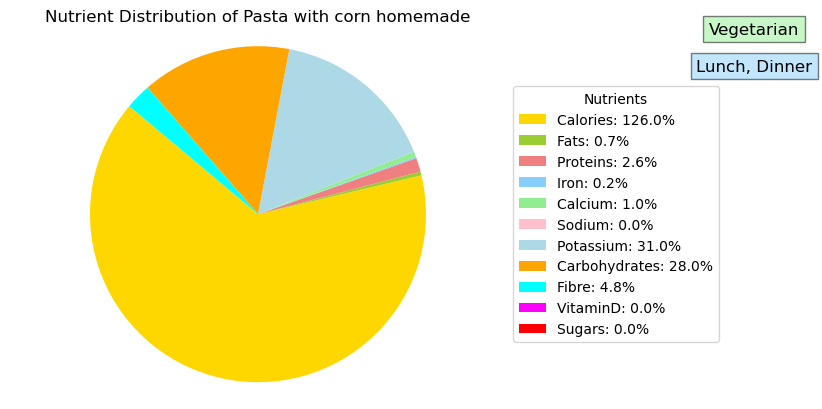

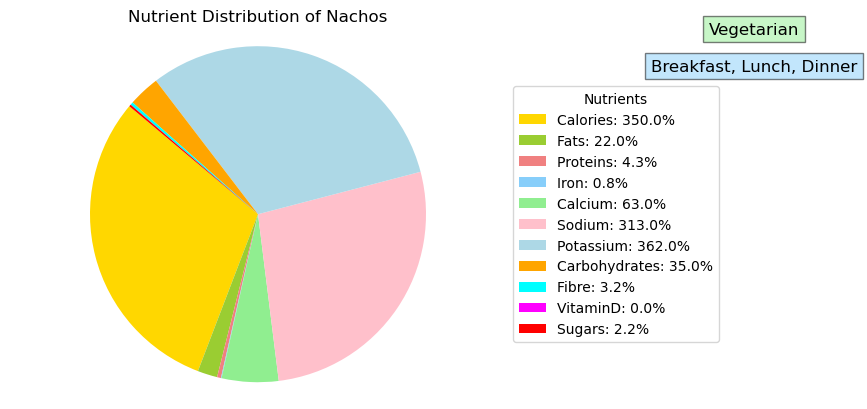

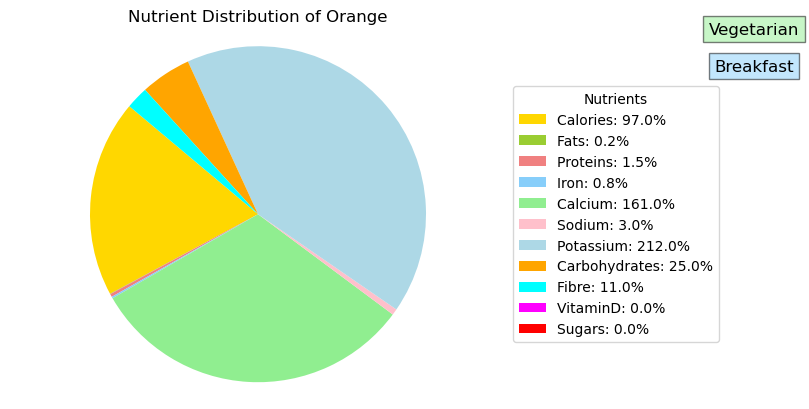

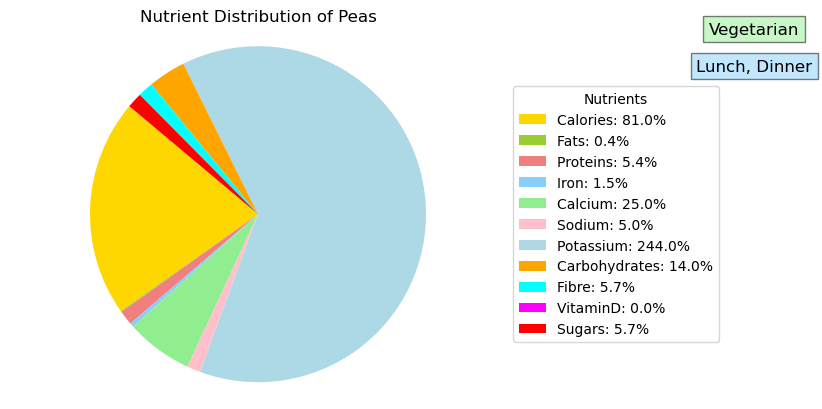

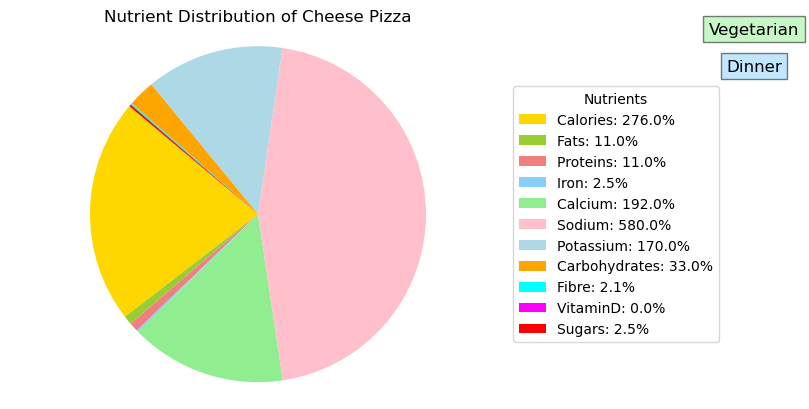

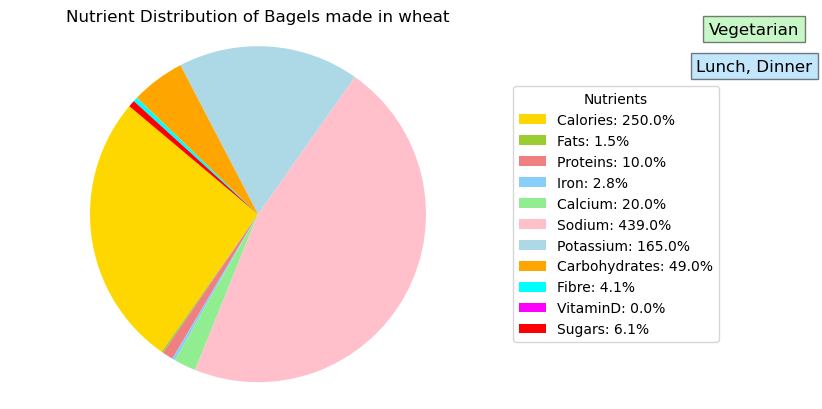

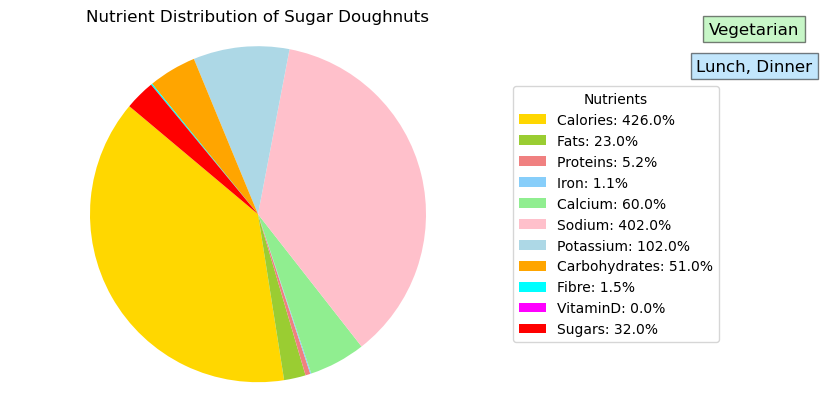

In [ ]:


def create_pie_chart(food, predicted_food_names):
    for food_name in predicted_food_names:
    # Perform fuzzy string matching to find the closest match
        match = process.extractOne(food_name, food['Food_items'])
        if match[1] >= 80:  # Adjust the threshold as needed
            food_item = match[0]  # Use the closest match
            item_row = food[food['Food_items'] == food_item]
            
            # Nutrient labels and sizes
            labels = ['Calories', 'Fats', 'Proteins', 'Iron', 'Calcium', 'Sodium',
                    'Potassium', 'Carbohydrates', 'Fibre', 'VitaminD', 'Sugars']
            sizes = item_row[labels].values[0]
            
            # Colors for the pie chart
            colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen',
                    'pink', 'lightblue', 'orange', 'cyan', 'magenta', 'red']
            
            # Create pie chart
            fig, ax = plt.subplots()
            wedges, _, _ = ax.pie(sizes, colors=colors, autopct='', startangle=140, textprops=dict(color="black"))
            
            # Add legend next to the pie chart
            ax.legend(wedges, [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)], title="Nutrients", loc="center left", bbox_to_anchor=(1, 0.5))
            
            # Include information about whether the food item is vegetarian or non-vegetarian
            veg_nonveg = item_row['VegNovVeg'].values[0]
            if veg_nonveg == 0:
                veg_label = 'Vegetarian'
            else:
                veg_label = 'Non-Vegetarian'
            plt.text(1.5, 1.0, f'{veg_label}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
            
            # Include information about meal type (breakfast, lunch, or dinner)
            meal_type = ''
            if item_row['Breakfast'].values[0] == 1:
                meal_type += 'Breakfast'
            if item_row['Lunch'].values[0] == 1:
                if meal_type:
                    meal_type += ', '
                meal_type += 'Lunch'
            if item_row['Dinner'].values[0] == 1:
                if meal_type:
                    meal_type += ', '
                meal_type += 'Dinner'
            plt.text(1.5, 0.9, f'{meal_type}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='lightskyblue', alpha=0.5))
            
            # Equal aspect ratio ensures that pie is drawn as a circle
            ax.axis('equal')  
            
            # Title for the pie chart
            plt.title(f'Nutrient Distribution of {food_item}')
            
            # Show the pie chart
            plt.show()
        else:
            print("Food item not found or not similar enough in the dataset.")   

create_pie_chart(food, predicted_food_names)